Data Preprocessing

Let's have a look at the VOC dataset. 

In [3]:
# import necessary libraries
import os
import random
import cv2
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import numpy as np
from tqdm import tqdm
import pandas as pd
import seaborn as sns
from collections import Counter
import json

Point to the library

In [5]:
# Define the paths
images_dir = r"C:\Users\curly\OneDrive\My Documents\Computer Science\Applied Machine Learning\Coursework\VOC2012\JPEGImages"
annot_dir = r"C:\Users\curly\OneDrive\My Documents\Computer Science\Applied Machine Learning\Coursework\VOC2012\Annotations"

Check passing dataset correctly by choosing and displaying a random sample. Show the image, the bounding box(es) and the combined image alongside each other. 

VOC2012 Dataset Explorer

Showing a random image example:


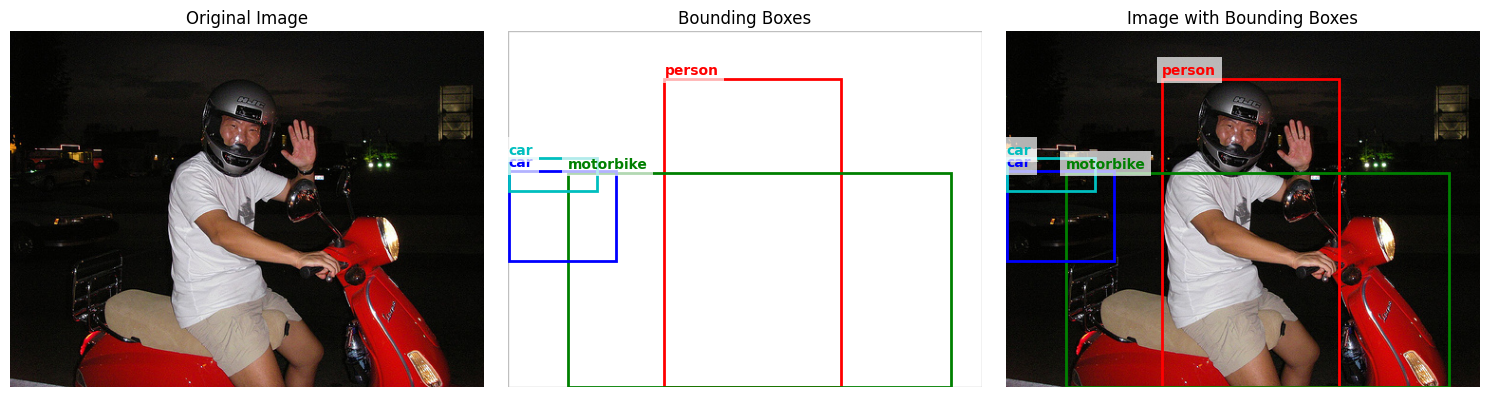

Image: 2008_004288.jpg
Objects: person, motorbike, car, car


In [6]:
def get_random_image_and_annotation():
    """Get a random image and its corresponding annotation file."""
    image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]
    random_img = random.choice(image_files)
    
    # Get base filename without extension
    base_name = os.path.splitext(random_img)[0]
    
    # Get corresponding annotation file
    annotation_file = os.path.join(annot_dir, base_name + '.xml')
    image_file = os.path.join(images_dir, random_img)
    
    return image_file, annotation_file

def parse_annotation(annotation_file):
    """Parse the XML annotation file to extract bounding boxes."""
    tree = ET.parse(annotation_file)
    root = tree.getroot()
    
    boxes = []
    classes = []
    
    for obj in root.findall('.//object'):
        class_name = obj.find('name').text
        bbox = obj.find('bndbox')
        
        # Convert coordinates to integers, handling floating point values
        xmin = int(float(bbox.find('xmin').text))
        ymin = int(float(bbox.find('ymin').text))
        xmax = int(float(bbox.find('xmax').text))
        ymax = int(float(bbox.find('ymax').text))
        
        boxes.append((xmin, ymin, xmax, ymax))
        classes.append(class_name)
    
    return boxes, classes

def show_dataset_example():
    """Show a random image with its bounding boxes."""
    image_file, annotation_file = get_random_image_and_annotation()
    boxes, classes = parse_annotation(annotation_file)
    
    # Load image
    img = Image.open(image_file)
    
    # Create figure with 3 subplots
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # 1. Show original image
    axes[0].imshow(img)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # 2. Show only bounding boxes
    axes[1].set_xlim(0, img.width)
    axes[1].set_ylim(img.height, 0)  # Invert y-axis to match image coordinates
    axes[1].set_title('Bounding Boxes')
    axes[1].set_aspect('equal')  # Set aspect ratio to equal
    axes[1].set_frame_on(False)  # Hide frame
    axes[1].tick_params(left=False, right=False, labelleft=False, 
                       labelbottom=False, bottom=False)  # Hide ticks
    
    # Draw a background with the same size as the image
    bg_rect = patches.Rectangle((0, 0), img.width, img.height, 
                               linewidth=1, edgecolor='gray', 
                               facecolor='white', alpha=0.5)
    axes[1].add_patch(bg_rect)
    
    # Add bounding boxes
    colors = ['r', 'g', 'b', 'c', 'm', 'y']
    for i, (box, class_name) in enumerate(zip(boxes, classes)):
        xmin, ymin, xmax, ymax = box
        color = colors[i % len(colors)]
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                 linewidth=2, edgecolor=color, facecolor='none')
        axes[1].add_patch(rect)
        # Add label with white background for better readability
        axes[1].text(xmin, ymin-5, class_name, color=color, fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    # 3. Show image with bounding boxes
    axes[2].imshow(img)
    axes[2].set_title('Image with Bounding Boxes')
    
    for i, (box, class_name) in enumerate(zip(boxes, classes)):
        xmin, ymin, xmax, ymax = box
        color = colors[i % len(colors)]
        rect = patches.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, 
                                 linewidth=2, edgecolor=color, facecolor='none')
        axes[2].add_patch(rect)
        # Add label with white background
        axes[2].text(xmin, ymin-5, class_name, color=color, fontweight='bold',
                    bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))
    
    axes[2].axis('off')
    
    # Ensure all subplots have the same dimensions
    for ax in axes:
        ax.set_xlim(0, img.width)
        ax.set_ylim(img.height, 0)
    
    # Adjust layout and display with equal spacing
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.05)  # Reduce space between subplots
    plt.show()
    
    # Print filename for reference
    print(f"Image: {os.path.basename(image_file)}")
    print(f"Objects: {', '.join([f'{c}' for c in classes])}")

print("VOC2012 Dataset Explorer")
print("=======================")
print("\nShowing a random image example:")
show_dataset_example()

With the data being passed correctly, the next step is to examine what data we have. 

Let's start with counting the number of images and the types of image in the dataset.

In [7]:
def count_images(extensions=('.jpg', '.jpeg', '.png')):
    """Count the number of image files in a directory by extension type."""

    if not os.path.isdir(images_dir):
        raise ValueError(f"Directory not found: {images_dir}")
    
    # Count files by extension
    counts = Counter()
    total_count = 0
    
    for filename in os.listdir(images_dir):
        ext = os.path.splitext(filename)[1].lower()
        if ext in extensions:
            counts[ext] += 1
            total_count += 1
    
    print(f"Total images: {total_count}")
    for ext, count in counts.items():
        print(f"  {ext}: {count}")
    
print("\nImage count analysis:")
count_images()


Image count analysis:
Total images: 17125
  .jpg: 17125


Analyse the image sizes and whether there are differences.

This shows clusters but differences in image heights, widths and aspect ratios.
**PRE-PROCESSING ACTION ** 
    Albumentations: Resize with Resize() or LongestMaxSize() + PadIfNeeded(), possibly include RandomCrop, HorizontalFlip. Need to consider bbox_params in Albumentations.
    MMDetection: Resize or ResizeKeepRatio, Pad or PadIfNeeded and possibly RandomFlip


Image size analysis:
Analyzing a random sample of 300 images
Sample widths (pixels): min=212, max=500, avg=468.0, range=288
Sample heights (pixels): min=200, max=500, avg=389.1, range=300
Sample aspect ratios: min=0.59, max=2.50, avg=1.25
Sample file sizes: min=16.0KB, max=229.4KB, avg=106.5KB, total=31.2MB


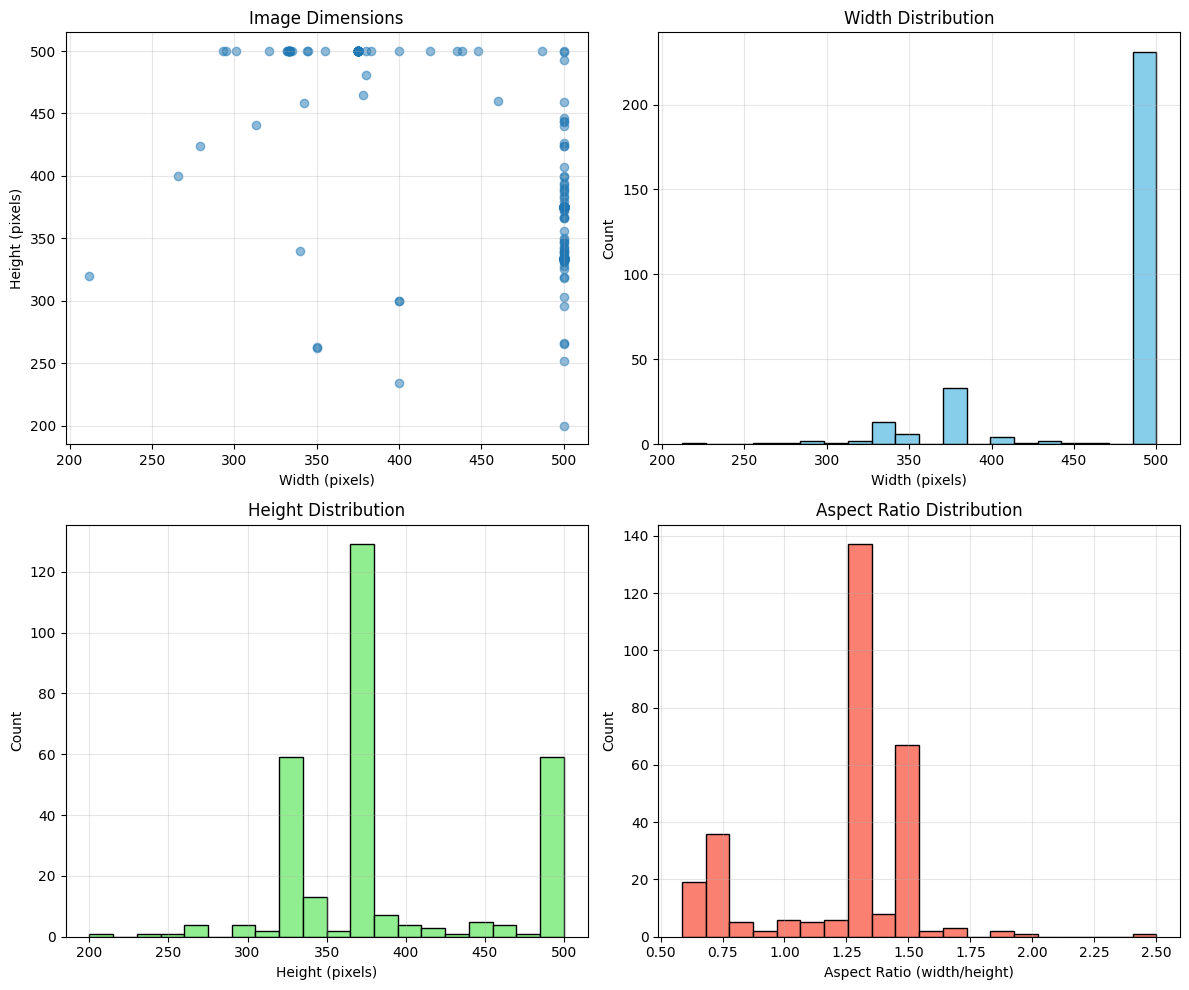

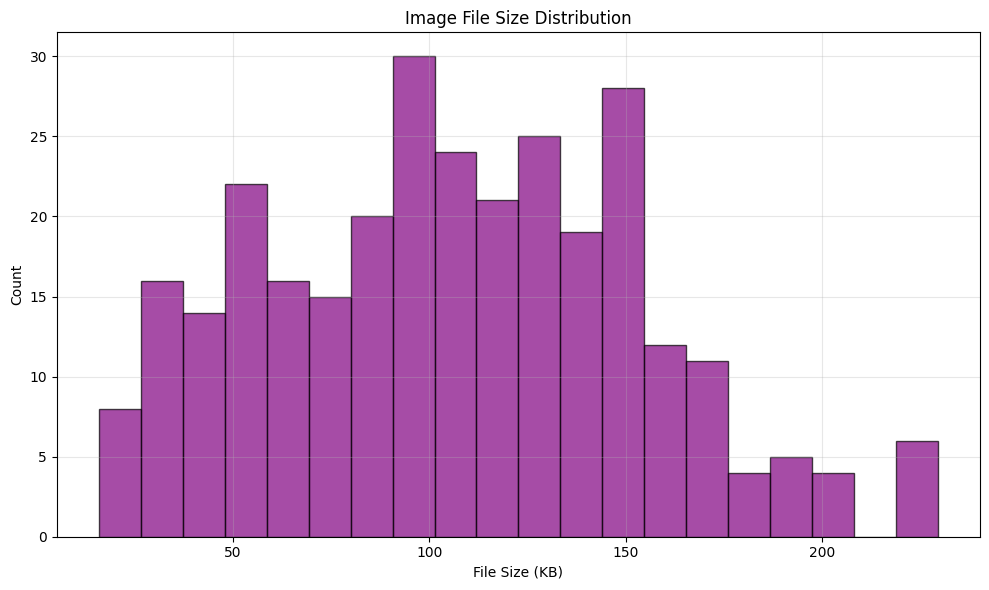

In [8]:
def analyze_image_sizes(extensions=('.jpg'), sample_size=None):
    """ Analyze the size of images in a directory and plot the results. """
   
    if not os.path.isdir(images_dir):
        raise ValueError(f"Directory not found: {images_dir}")
    
    # Get list of image files
    image_files = [f for f in os.listdir(images_dir) if os.path.splitext(f)[1].lower() in extensions]
    
    # Sample if requested
    image_files = random.sample(image_files, sample_size)
    print(f"Analyzing a random sample of {sample_size} images")
    
    widths = []
    heights = []
    aspect_ratios = []
    file_sizes = []  # in KB
    
    # Collect size data
    for img_file in image_files:
        img_path = os.path.join(images_dir, img_file)
        try:
            # Get image dimensions
            with Image.open(img_path) as img:
                width, height = img.size
                widths.append(width)
                heights.append(height)
                aspect_ratios.append(width / height)
            
            # Get file size in KB
            file_sizes.append(os.path.getsize(img_path) / 1024)
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
    
    if not widths:  # No valid images found
        return None
    
    # Calculate statistics
    stats = {
        'width': {
            'min': min(widths),
            'max': max(widths),
            'avg': sum(widths) / len(widths),
            'range': max(widths) - min(widths)
        },
        'height': {
            'min': min(heights),
            'max': max(heights),
            'avg': sum(heights) / len(heights),
            'range': max(heights) - min(heights)
        },
        'aspect_ratio': {
            'min': min(aspect_ratios),
            'max': max(aspect_ratios),
            'avg': sum(aspect_ratios) / len(aspect_ratios)
        },
        'file_size': {  # in KB
            'min': min(file_sizes),
            'max': max(file_sizes),
            'avg': sum(file_sizes) / len(file_sizes),
            'total': sum(file_sizes)  # Total size in KB
        }
    }
    
    # Print summary statistics
    print(f"Sample widths (pixels): min={stats['width']['min']}, max={stats['width']['max']}, "
          f"avg={stats['width']['avg']:.1f}, range={stats['width']['range']}")
    print(f"Sample heights (pixels): min={stats['height']['min']}, max={stats['height']['max']}, "
          f"avg={stats['height']['avg']:.1f}, range={stats['height']['range']}")
    print(f"Sample aspect ratios: min={stats['aspect_ratio']['min']:.2f}, max={stats['aspect_ratio']['max']:.2f}, "
          f"avg={stats['aspect_ratio']['avg']:.2f}")
    print(f"Sample file sizes: min={stats['file_size']['min']:.1f}KB, max={stats['file_size']['max']:.1f}KB, "
          f"avg={stats['file_size']['avg']:.1f}KB, total={stats['file_size']['total']/1024:.1f}MB")
    
    # Create scatter plot of image dimensions
    plt.figure(figsize=(12, 10))
    
    # Main plot: 2x2 grid
    plt.subplot(2, 2, 1)
    plt.scatter(widths, heights, alpha=0.5)
    plt.xlabel('Width (pixels)')
    plt.ylabel('Height (pixels)')
    plt.title('Image Dimensions')
    plt.grid(True, alpha=0.3)
    
    # Add histogram of widths
    plt.subplot(2, 2, 2)
    plt.hist(widths, bins=20, color='skyblue', edgecolor='black')
    plt.xlabel('Width (pixels)')
    plt.ylabel('Count')
    plt.title('Width Distribution')
    plt.grid(True, alpha=0.3)
    
    # Add histogram of heights
    plt.subplot(2, 2, 3)
    plt.hist(heights, bins=20, color='lightgreen', edgecolor='black')
    plt.xlabel('Height (pixels)')
    plt.ylabel('Count')
    plt.title('Height Distribution')
    plt.grid(True, alpha=0.3)
    
    # Add histogram of aspect ratios
    plt.subplot(2, 2, 4)
    plt.hist(aspect_ratios, bins=20, color='salmon', edgecolor='black')
    plt.xlabel('Aspect Ratio (width/height)')
    plt.ylabel('Count')
    plt.title('Aspect Ratio Distribution')
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Additional plot for file sizes
    plt.figure(figsize=(10, 6))
    plt.hist(file_sizes, bins=20, color='purple', alpha=0.7, edgecolor='black')
    plt.xlabel('File Size (KB)')
    plt.ylabel('Count')
    plt.title('Image File Size Distribution')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
print ("\nImage size analysis:")
analyze_image_sizes(sample_size=300)  # Analyze a sample of 100 images

Calculate the number of catagories

In [9]:
def count_categories():
    """Count unique object categories in the dataset and print them."""
    
    all_classes = []
    
    # Process all annotation files
    for xml_file in os.listdir(annot_dir):
        if xml_file.endswith('.xml'):
            annotation_file = os.path.join(annot_dir, xml_file)
            _, classes = parse_annotation(annotation_file)
            all_classes.extend(classes)
    
    # Count unique categories
    category_counts = Counter(all_classes)
    
    # Print results
    print(f"\nFound {len(category_counts)} unique categories:")
    for category, count in sorted(category_counts.items(), key=lambda x: x[1], reverse=True):
        print(f"  - {category}: {count} instances")

count_categories()


Found 20 unique categories:
  - person: 17401 instances
  - chair: 3056 instances
  - car: 2492 instances
  - dog: 1598 instances
  - bottle: 1561 instances
  - cat: 1277 instances
  - bird: 1271 instances
  - pottedplant: 1202 instances
  - sheep: 1084 instances
  - boat: 1059 instances
  - aeroplane: 1002 instances
  - tvmonitor: 893 instances
  - sofa: 841 instances
  - bicycle: 837 instances
  - horse: 803 instances
  - motorbike: 801 instances
  - diningtable: 800 instances
  - cow: 771 instances
  - train: 704 instances
  - bus: 685 instances


Review the distribution of categories across images

This shows a skewed distribution. Consider in the test/train split. Also consider in performance checking - Standard mAP (mean Average Precision) is macro-averaged.

** PRE-PROCESSING ACTION ** Instance-level balancing (repeat minority-class images more often) and due consideration in the test/train split.
    
    Albumentations: Consider stronger augmentation of rare classes or over-sampling rare classes.
    
    MMDetection: ClassBalancedDataset:


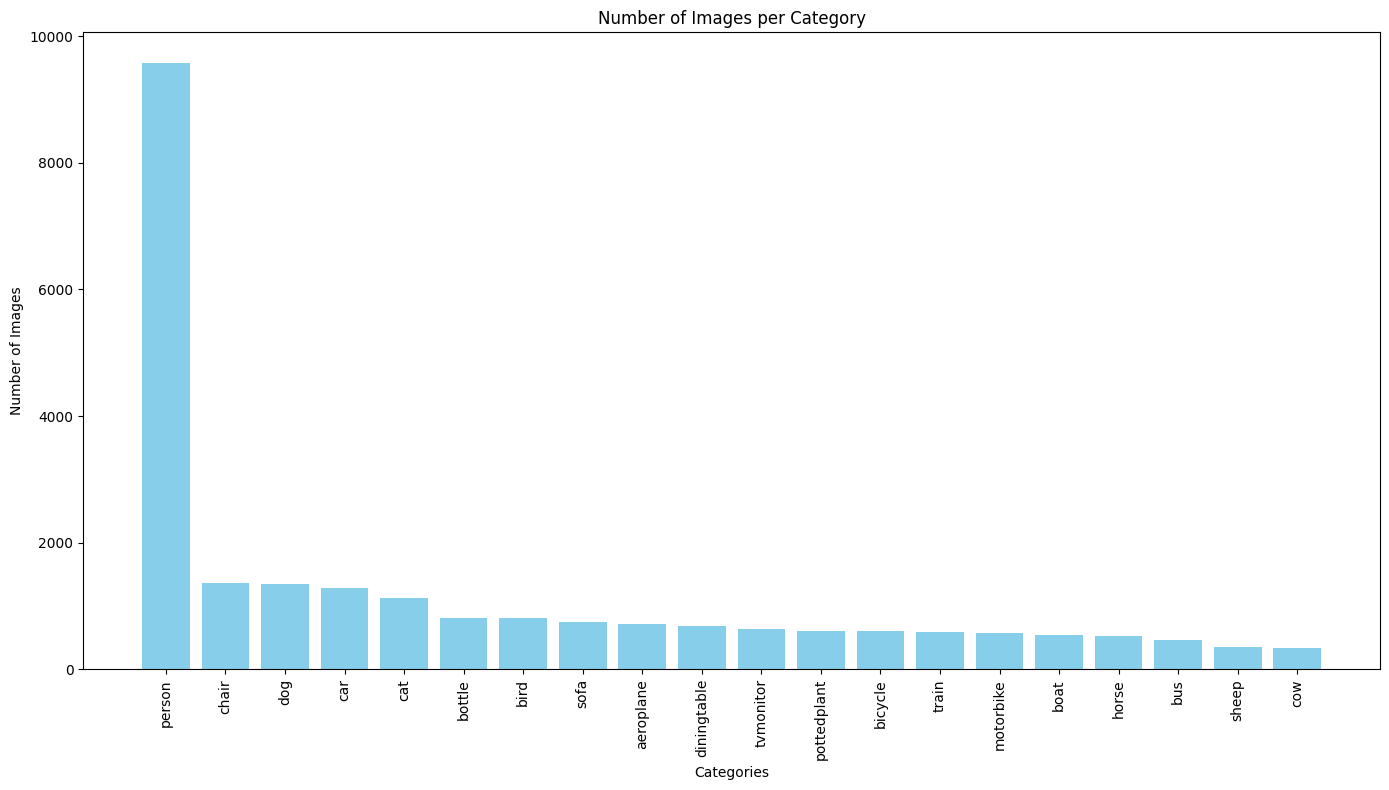


Found 20 categories spread across images
The following categories appear in this many images:
  1. person: appears in 9583 images
  2. chair: appears in 1366 images
  3. dog: appears in 1341 images
  4. car: appears in 1284 images
  5. cat: appears in 1128 images
  6. bottle: appears in 812 images
  7. bird: appears in 811 images
  8. sofa: appears in 742 images
  9. aeroplane: appears in 716 images
  10. diningtable: appears in 691 images
  11. tvmonitor: appears in 645 images
  12. pottedplant: appears in 613 images
  13. bicycle: appears in 603 images
  14. train: appears in 589 images
  15. motorbike: appears in 575 images
  16. boat: appears in 549 images
  17. horse: appears in 526 images
  18. bus: appears in 467 images
  19. sheep: appears in 357 images
  20. cow: appears in 340 images


In [19]:
def count_images_per_category():
    """Count how many images contain each category and plot a bar chart."""
    
    # Dictionary to store categories and their image counts
    category_image_counts = Counter()
    
    # Process all annotation files
    for xml_file in os.listdir(annot_dir):
        if xml_file.endswith('.xml'):
            annotation_file = os.path.join(annot_dir, xml_file)
            _, classes = parse_annotation(annotation_file)
            
            # Add unique categories from this image
            unique_classes = set(classes)
            for category in unique_classes:
                category_image_counts[category] += 1
    
    # Sort categories by image count (descending)
    sorted_categories = sorted(category_image_counts.items(), key=lambda x: x[1], reverse=True)
    categories, counts = zip(*sorted_categories)
    
    # Create bar chart
    plt.figure(figsize=(14, 8))
    plt.bar(categories, counts, color='skyblue')
    plt.xlabel('Categories')
    plt.ylabel('Number of Images')
    plt.title('Number of Images per Category')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    
    print(f"\nFound {len(category_image_counts)} categories spread across images")
    print(f"The following categories appear in this many images:")
    for i, (category, count) in enumerate(sorted_categories[::]):
        print(f"  {i+1}. {category}: appears in {count} images")

count_images_per_category()


Co-occurance of objects in a image

Consider context aware training? Multi-class recall? Are we going to train on co-occurring classes?

** PRE-PROCESSING ACTION **
    Pre-tag your images by co-occurrence? Data-mine using co-occurrance to find errors in the dataset.
    Albumentation: Avoid breaking class context. Use safe cropping (BBoxSafeRandomCrop)
    


Analyzing co-occurrence of object classes...
Processed 17125 annotation files.
Found 20 unique object classes.

Class occurrence counts:
  person: 17401
  chair: 3056
  car: 2492
  dog: 1598
  bottle: 1561
  cat: 1277
  bird: 1271
  pottedplant: 1202
  sheep: 1084
  boat: 1059
  aeroplane: 1002
  tvmonitor: 893
  sofa: 841
  bicycle: 837
  horse: 803
  motorbike: 801
  diningtable: 800
  cow: 771
  train: 704
  bus: 685
Processed 17125 annotation files.
Found 20 unique object classes.

Class occurrence counts:
  person: 17401
  chair: 3056
  car: 2492
  dog: 1598
  bottle: 1561
  cat: 1277
  bird: 1271
  pottedplant: 1202
  sheep: 1084
  boat: 1059
  aeroplane: 1002
  tvmonitor: 893
  sofa: 841
  bicycle: 837
  horse: 803
  motorbike: 801
  diningtable: 800
  cow: 771
  train: 704
  bus: 685


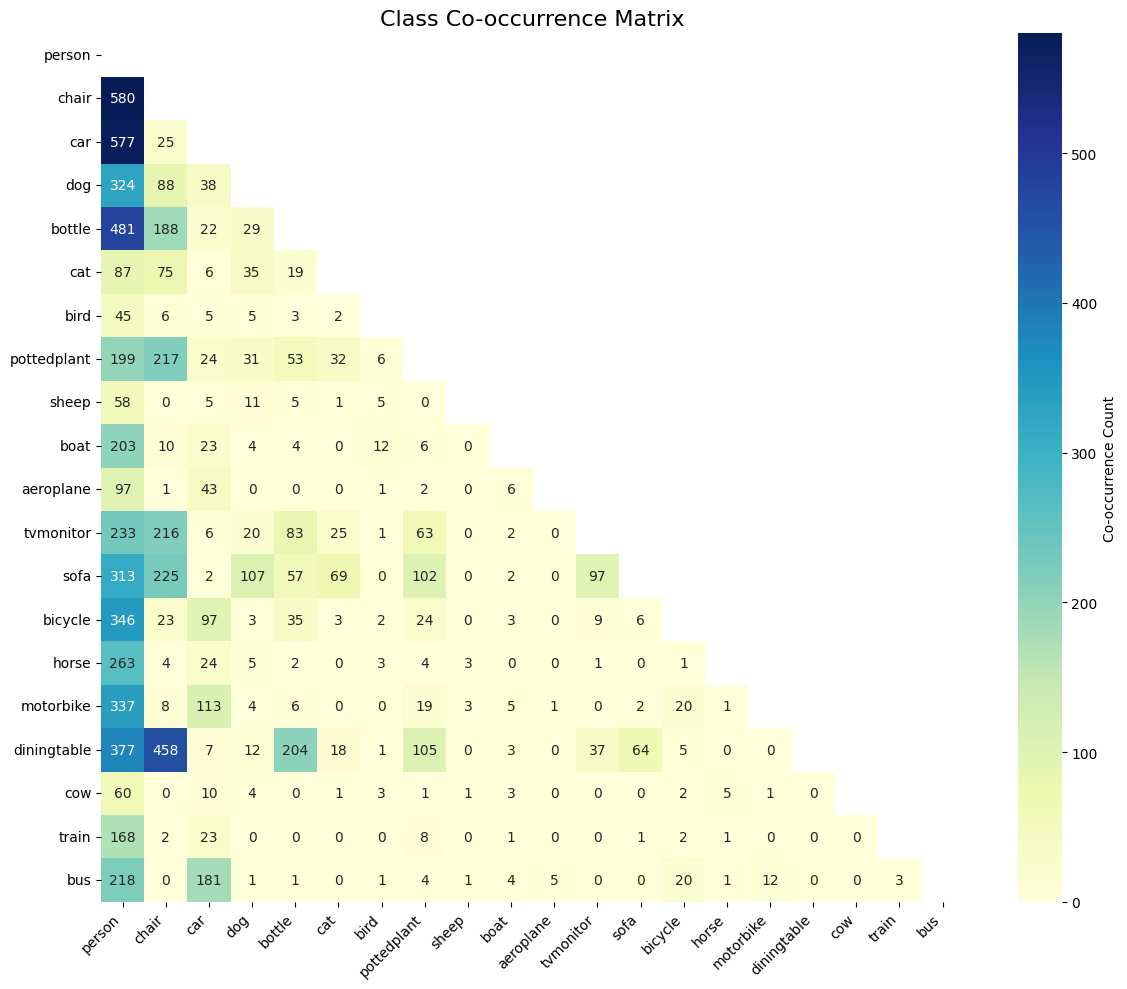

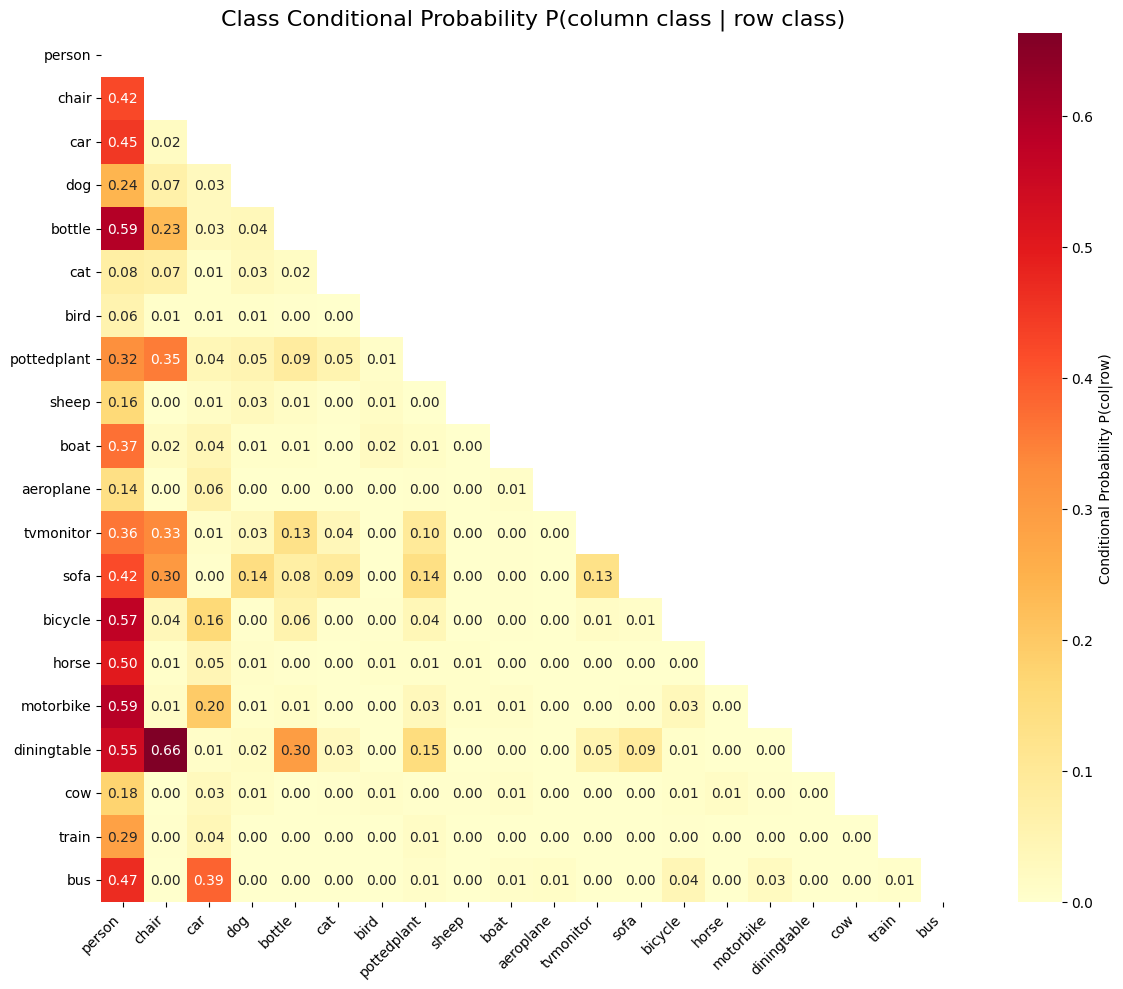

In [20]:
def analyze_co_occurrence(min_occurrence=1, top_n=None):
    """Identify which object classes frequently appear together in images.
    
    This function analyzes XML annotation files to find object co-occurrences
    and displays the results as heatmaps.
    
    Args:
        annot_dir (str): Directory containing annotation XML files
        min_occurrence (int): Minimum number of occurrences to include in visualization
        top_n (int, optional): Only show top N most frequent classes (None = show all)
    """
    print("Analyzing co-occurrence of object classes...")
    
    # Check if directory exists
    if not os.path.isdir(annot_dir):
        raise ValueError(f"Annotation directory not found: {annot_dir}")
    
    # Get all XML files
    xml_files = [f for f in os.listdir(annot_dir) if f.endswith('.xml')]
    
    if not xml_files:
        print("No XML annotation files found.")
        return
    
    # Dictionary to store classes in each image
    image_classes = {}
    # Counter for overall class frequency
    class_counter = Counter()
    
    # Process each annotation file
    for xml_file in xml_files:
        try:
            tree = ET.parse(os.path.join(annot_dir, xml_file))
            root = tree.getroot()
            
            # Get base filename without extension
            base_name = os.path.splitext(xml_file)[0]
            
            # Get all object classes in this image
            classes_in_image = []
            for obj in root.findall('.//object'):
                class_name = obj.find('name').text
                classes_in_image.append(class_name)
                class_counter[class_name] += 1
            
            # Store unique classes for this image
            image_classes[base_name] = set(classes_in_image)
            
        except Exception as e:
            print(f"Error processing {xml_file}: {e}")
    
    print(f"Processed {len(xml_files)} annotation files.")
    print(f"Found {len(class_counter)} unique object classes.")
    
    # Sort classes by frequency
    sorted_classes = [cls for cls, count in class_counter.most_common()]
    
    # Apply top_n filter if specified
    if top_n and len(sorted_classes) > top_n:
        print(f"Limiting analysis to top {top_n} most frequent classes")
        sorted_classes = sorted_classes[:top_n]
    
    # Apply minimum occurrence filter
    if min_occurrence > 1:
        filtered_classes = [cls for cls in sorted_classes if class_counter[cls] >= min_occurrence]
        if len(filtered_classes) < len(sorted_classes):
            print(f"Filtered out {len(sorted_classes) - len(filtered_classes)} classes with fewer than {min_occurrence} occurrences")
            sorted_classes = filtered_classes
    
    # Create co-occurrence matrix
    n_classes = len(sorted_classes)
    co_occurrence = np.zeros((n_classes, n_classes), dtype=int)
    
    # Fill co-occurrence matrix
    for img_classes in image_classes.values():
        # Get classes in this image that are in our filtered list
        img_classes_filtered = [cls for cls in img_classes if cls in sorted_classes]
        
        # For each pair of classes in this image, increment co-occurrence
        for i, cls1 in enumerate(sorted_classes):
            if cls1 in img_classes_filtered:
                for j, cls2 in enumerate(sorted_classes):
                    if cls2 in img_classes_filtered:
                        co_occurrence[i, j] += 1
    
    # Create a DataFrame for easier visualization
    co_matrix_df = pd.DataFrame(co_occurrence, index=sorted_classes, columns=sorted_classes)
    
    # Print class counts
    print("\nClass occurrence counts:")
    for cls in sorted_classes:
        print(f"  {cls}: {class_counter[cls]}")
    
    # Visualize the co-occurrence matrix
    plt.figure(figsize=(12, 10))
    mask = np.triu(np.ones_like(co_matrix_df, dtype=bool))  # Create mask for upper triangle
    
    # Set up the heatmap
    sns.heatmap(co_matrix_df, annot=True, fmt="d", cmap="YlGnBu", 
                mask=mask, cbar_kws={'label': 'Co-occurrence Count'})
    
    plt.title("Class Co-occurrence Matrix", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    # Calculate and visualize co-occurrence probability
    # This shows P(class B | class A) - probability of seeing class B given class A is present
    prob_matrix = np.zeros((n_classes, n_classes))
    for i in range(n_classes):
        for j in range(n_classes):
            if co_occurrence[i, i] > 0:  # Avoid division by zero
                prob_matrix[i, j] = co_occurrence[i, j] / co_occurrence[i, i]
    
    prob_df = pd.DataFrame(prob_matrix, index=sorted_classes, columns=sorted_classes)
    
    plt.figure(figsize=(12, 10))
    # Set up the conditional probability heatmap
    sns.heatmap(prob_df, annot=True, fmt=".2f", cmap="YlOrRd", 
                mask=mask, cbar_kws={'label': 'Conditional Probability P(col|row)'})
    
    plt.title("Class Conditional Probability P(column class | row class)", fontsize=16)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

analyze_co_occurrence() 

Examine the aspect ratio of the objects. Objects have very different ARs, which can support identifcation. 

** PRE-PROCESSING ACTION ** Can use the aspect ratio to train a second model to check for errors. 
    
    Albumentations: LongestMaxSize, PadIfNeeded. Use Affine or Rotate carefully - a car is unlikely to be vertical in an immage so apply milder transforms to sensitive aspect-ratio categories.
    
    MMDetection: img_scale=(), resize_keep_ratio=True

Analyzing bounding box aspect ratio by category
Found 17125 XML files
Loaded 40138 bounding boxes across 20 categories
Loaded 40138 bounding boxes across 20 categories

Aspect Ratio Statistics by Category:
             mean  median   std
category                       
aeroplane    0.50    0.41  0.25
bicycle      1.08    0.87  0.60
bird         1.13    0.99  0.61
boat         0.90    0.67  0.69
bottle       2.40    2.50  0.95
bus          0.94    0.77  0.59
car          0.77    0.64  0.49
cat          0.99    0.89  0.44
chair        1.38    1.30  0.65
cow          1.02    0.86  0.55
diningtable  0.71    0.61  0.43
dog          1.06    0.97  0.45
horse        1.25    1.05  0.62
motorbike    1.02    0.83  0.55
person       1.84    1.70  0.80
pottedplant  1.41    1.24  0.68
sheep        1.01    0.88  0.48
sofa         0.77    0.67  0.41
train        0.78    0.66  0.47
tvmonitor    1.02    0.93  0.45

Aspect Ratio Statistics by Category:
             mean  median   std
category            

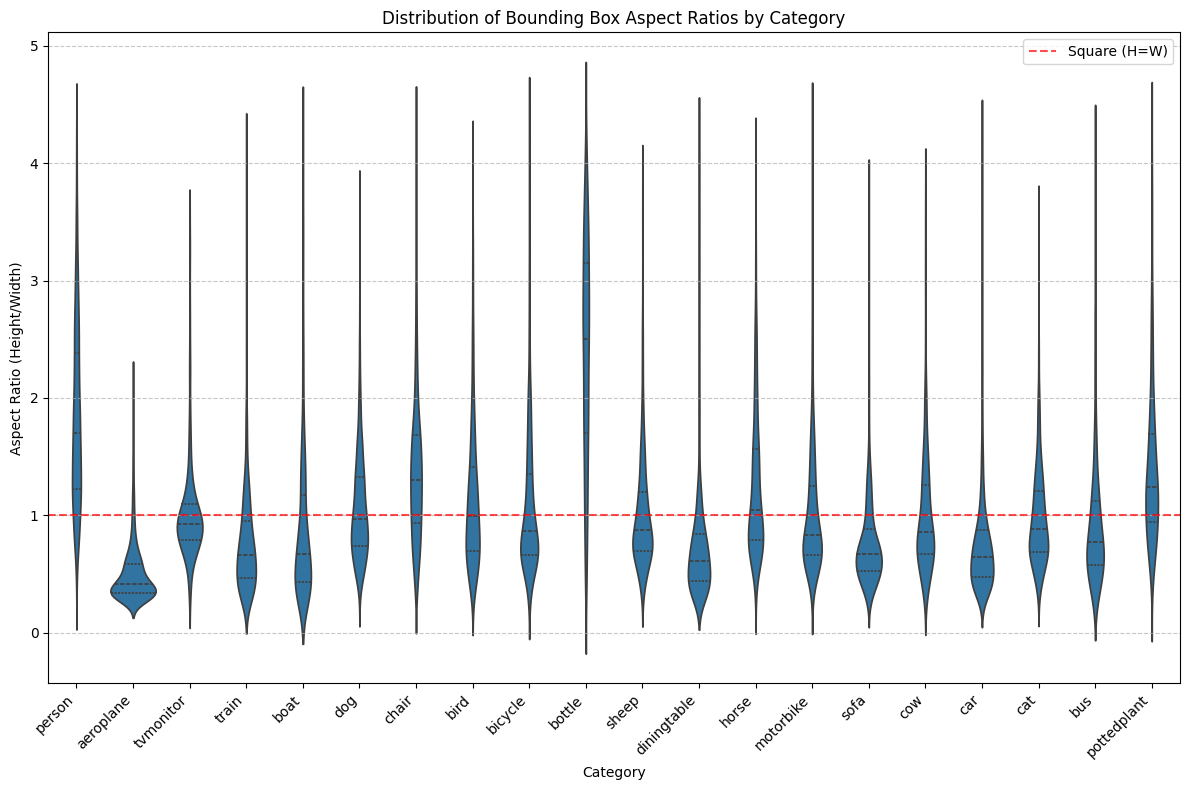

In [21]:
def aspect_ratio_distribution():
    """Analyze and plot height/width ratios of bounding boxes by category."""
    print(f"Analyzing bounding box aspect ratio by category")
    
    try:
        # Use the global annot_dir variable
        aspect_ratios = []
        categories = []
        
        # Process all XML files in the annotation directory
        xml_files = [f for f in os.listdir(annot_dir) if f.endswith('.xml')]
        print(f"Found {len(xml_files)} XML files")
        
        for filename in xml_files:
            file_path = os.path.join(annot_dir, filename)
            
            # Parse XML file
            tree = ET.parse(file_path)
            root = tree.getroot()
            
            # Extract objects (annotations)
            for obj in root.findall('./object'):
                # Get category name
                category_name = obj.find('name').text
                
                # Get bounding box dimensions
                bbox = obj.find('bndbox')
                if bbox is not None:
                    xmin = float(bbox.find('xmin').text)
                    ymin = float(bbox.find('ymin').text)
                    xmax = float(bbox.find('xmax').text)
                    ymax = float(bbox.find('ymax').text)
                    
                    # Calculate width and height
                    width = xmax - xmin
                    height = ymax - ymin
                    
                    if width > 0:  # Avoid division by zero
                        aspect_ratio = height / width
                        
                        aspect_ratios.append(aspect_ratio)
                        categories.append(category_name)
        
        # Check if we actually loaded any data
        if not aspect_ratios:
            print("No annotation data found. Please check the annotation directory and file format.")
            return
            
        # Create DataFrame with collected data
        data = pd.DataFrame({
            'category': categories,
            'aspect_ratio': aspect_ratios
        })
        
        print(f"Loaded {len(data)} bounding boxes across {data['category'].nunique()} categories")
        
        # Remove extreme outliers (1% and 99%)
        q1 = data['aspect_ratio'].quantile(0.01)
        q3 = data['aspect_ratio'].quantile(0.99)
        filtered_data = data[(data['aspect_ratio'] >= q1) & (data['aspect_ratio'] <= q3)]
        
        # Create visualization
        plt.figure(figsize=(12, 8))
        sns.violinplot(x='category', y='aspect_ratio', data=filtered_data, inner='quartile')
        plt.axhline(y=1, color='r', linestyle='--', alpha=0.7, label='Square (H=W)')
        
        # Format plot
        plt.xlabel('Category')
        plt.ylabel('Aspect Ratio (Height/Width)')
        plt.title('Distribution of Bounding Box Aspect Ratios by Category')
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.legend()
        
        # Display statistics
        stats = filtered_data.groupby('category')['aspect_ratio'].agg(['mean', 'median', 'std']).round(2)
        print("\nAspect Ratio Statistics by Category:")
        print(stats)
        
        # Save and show plot
        plt.savefig("aspect_ratio_distribution.png", bbox_inches='tight', dpi=300)
        print("Plot saved to aspect_ratio_distribution.png")
        plt.show()
        
    except Exception as e:
        print(f"Error analyzing aspect ratios: {e}")

aspect_ratio_distribution()



Examine where the objects appear in the image

More effective for performance analysis. Training with position-aware consistency may be hard. Possible custom YOLO implementation - i.e Set anchor boxes to be more dense in “hot zones” where more objects appear?

** PRE-PROCESSING ACTION ** 
    
    Albumentations: Consider A.lambda

Analyzing spatial distribution of objects...
Found 17125 XML files
Loaded 40138 objects across 20 categories
Loaded 40138 objects across 20 categories
Plot saved to spatial_distribution.png
Plot saved to spatial_distribution.png


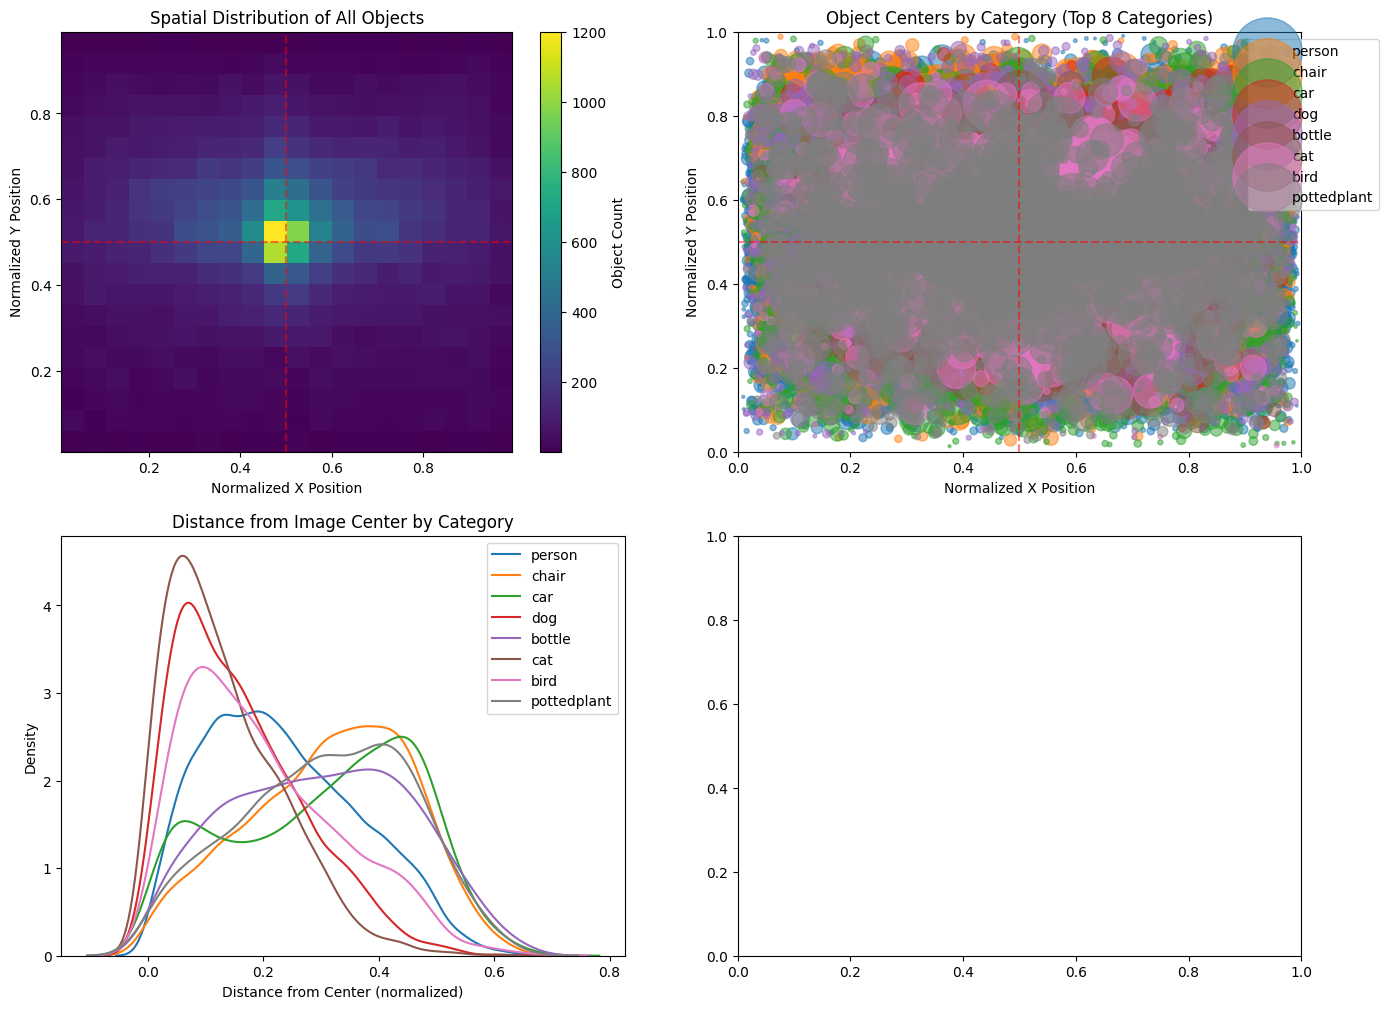

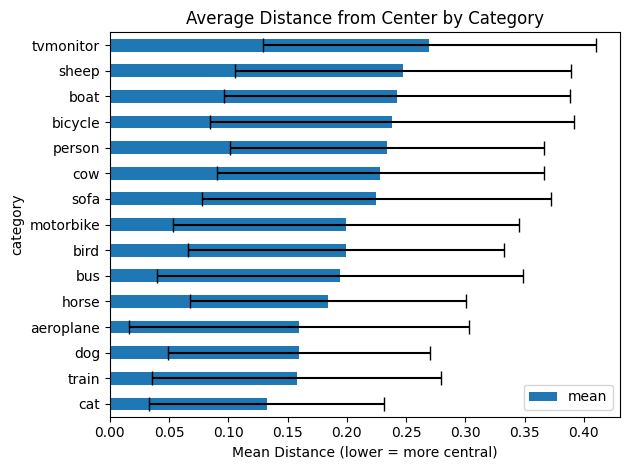


Category Centrality Statistics (sorted from most central to peripheral):
             count      mean       std
category                              
cat           1277  0.132242  0.099538
train          704  0.157504  0.122332
dog           1598  0.159693  0.110745
aeroplane     1002  0.159894  0.143474
horse          803  0.184131  0.116376
bus            685  0.194131  0.154288
bird          1271  0.199245  0.133182
motorbike      801  0.199490  0.146032
sofa           841  0.224881  0.147385
cow            771  0.228138  0.138024
person       17401  0.234022  0.132609
bicycle        837  0.237884  0.153549
boat          1059  0.242331  0.145672
sheep         1084  0.247462  0.141497
tvmonitor      893  0.269536  0.140523
diningtable    800  0.292188  0.127371
bottle        1561  0.298164  0.153557
car           2492  0.304682  0.160574
pottedplant   1202  0.307040  0.146045
chair         3056  0.314035  0.140263


In [22]:
def spatial_analysis():
    """Plot where objects tend to appear in images (center vs. periphery)"""
    print("Analyzing spatial distribution of objects...")
    
    try:
        # Lists to store normalized center coordinates and categories
        center_x = []
        center_y = []
        categories = []
        sizes = []  # To store relative box sizes
        
        # Process all XML files in the annotation directory
        xml_files = [f for f in os.listdir(annot_dir) if f.endswith('.xml')]
        print(f"Found {len(xml_files)} XML files")
        
        for filename in xml_files:
            file_path = os.path.join(annot_dir, filename)
            
            # Parse XML file
            tree = ET.parse(file_path)
            root = tree.getroot()
            
            # Get image dimensions
            img_width = float(root.find('./size/width').text)
            img_height = float(root.find('./size/height').text)
            
            # Extract objects (annotations)
            for obj in root.findall('./object'):
                # Get category name
                category_name = obj.find('name').text
                
                # Get bounding box dimensions
                bbox = obj.find('bndbox')
                if bbox is not None:
                    xmin = float(bbox.find('xmin').text)
                    ymin = float(bbox.find('ymin').text)
                    xmax = float(bbox.find('xmax').text)
                    ymax = float(bbox.find('ymax').text)
                    
                    # Calculate center coordinates (normalized to [0,1])
                    cx = ((xmin + xmax) / 2) / img_width
                    cy = ((ymin + ymax) / 2) / img_height
                    
                    # Calculate relative box size (area divided by image area)
                    box_area = (xmax - xmin) * (ymax - ymin)
                    relative_size = box_area / (img_width * img_height)
                    
                    center_x.append(cx)
                    center_y.append(cy)
                    categories.append(category_name)
                    sizes.append(relative_size)
        
        # Check if we actually loaded any data
        if not center_x:
            print("No annotation data found. Please check the annotation directory and file format.")
            return
            
        # Create DataFrame with collected data
        data = pd.DataFrame({
            'category': categories,
            'center_x': center_x,
            'center_y': center_y,
            'relative_size': sizes
        })
        
        print(f"Loaded {len(data)} objects across {data['category'].nunique()} categories")
        
        # Create visualization
        plt.figure(figsize=(16, 12))
        
        # 1. Overall heatmap
        plt.subplot(2, 2, 1)
        plt.hist2d(data['center_x'], data['center_y'], bins=20, cmap='viridis')
        plt.colorbar(label='Object Count')
        plt.title('Spatial Distribution of All Objects')
        plt.xlabel('Normalized X Position')
        plt.ylabel('Normalized Y Position')
        
        # Add crosshairs at the center
        plt.axvline(x=0.5, color='r', linestyle='--', alpha=0.5)
        plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
        
        # 2. Scatter plot by category
        plt.subplot(2, 2, 2)
        top_categories = data['category'].value_counts().nlargest(8).index
        for category in top_categories:
            subset = data[data['category'] == category]
            plt.scatter(subset['center_x'], subset['center_y'], 
                       s=subset['relative_size']*5000, 
                       alpha=0.5, label=category)
        
        plt.title('Object Centers by Category (Top 8 Categories)')
        plt.xlabel('Normalized X Position')
        plt.ylabel('Normalized Y Position')
        plt.axvline(x=0.5, color='r', linestyle='--', alpha=0.5)
        plt.axhline(y=0.5, color='r', linestyle='--', alpha=0.5)
        plt.xlim(0, 1)
        plt.ylim(0, 1)
        plt.legend(loc='upper right', bbox_to_anchor=(1.15, 1))
        
        # 3. Distance from center distribution
        plt.subplot(2, 2, 3)
        # Calculate distance from center (0.5, 0.5)
        data['dist_from_center'] = np.sqrt((data['center_x'] - 0.5)**2 + (data['center_y'] - 0.5)**2)
        
        # Plot distance distribution for top categories
        for category in top_categories:
            subset = data[data['category'] == category]
            sns.kdeplot(subset['dist_from_center'], label=category)
            
        plt.title('Distance from Image Center by Category')
        plt.xlabel('Distance from Center (normalized)')
        plt.ylabel('Density')
        plt.legend()
        
        # 4. Calculate centrality stats by category
        plt.subplot(2, 2, 4)
        
        centrality = data.groupby('category')['dist_from_center'].agg(['mean', 'std']).sort_values('mean')
        centrality = centrality.head(15)  # Top 15 categories
        
        centrality.plot(kind='barh', y='mean', xerr='std', capsize=5)
        plt.title('Average Distance from Center by Category')
        plt.xlabel('Mean Distance (lower = more central)')
        plt.tight_layout()
        
        # Save the plots
        plt.savefig("spatial_distribution.png", bbox_inches='tight', dpi=300)
        print("Plot saved to spatial_distribution.png")
        plt.show()
        
        # Print some statistics
        print("\nCategory Centrality Statistics (sorted from most central to peripheral):")
        stats = data.groupby('category')['dist_from_center'].agg(['count', 'mean', 'std']).sort_values('mean')
        print(stats)
        
    except Exception as e:
        print(f"Error analyzing spatial distribution: {e}")

spatial_analysis()

Explore image brightness

Analyzing brightness distribution by category...
Found 17125 XML files
Error analyzing brightness distribution: num must be an integer with 1 <= num <= 16, not 17
Error analyzing brightness distribution: num must be an integer with 1 <= num <= 16, not 17


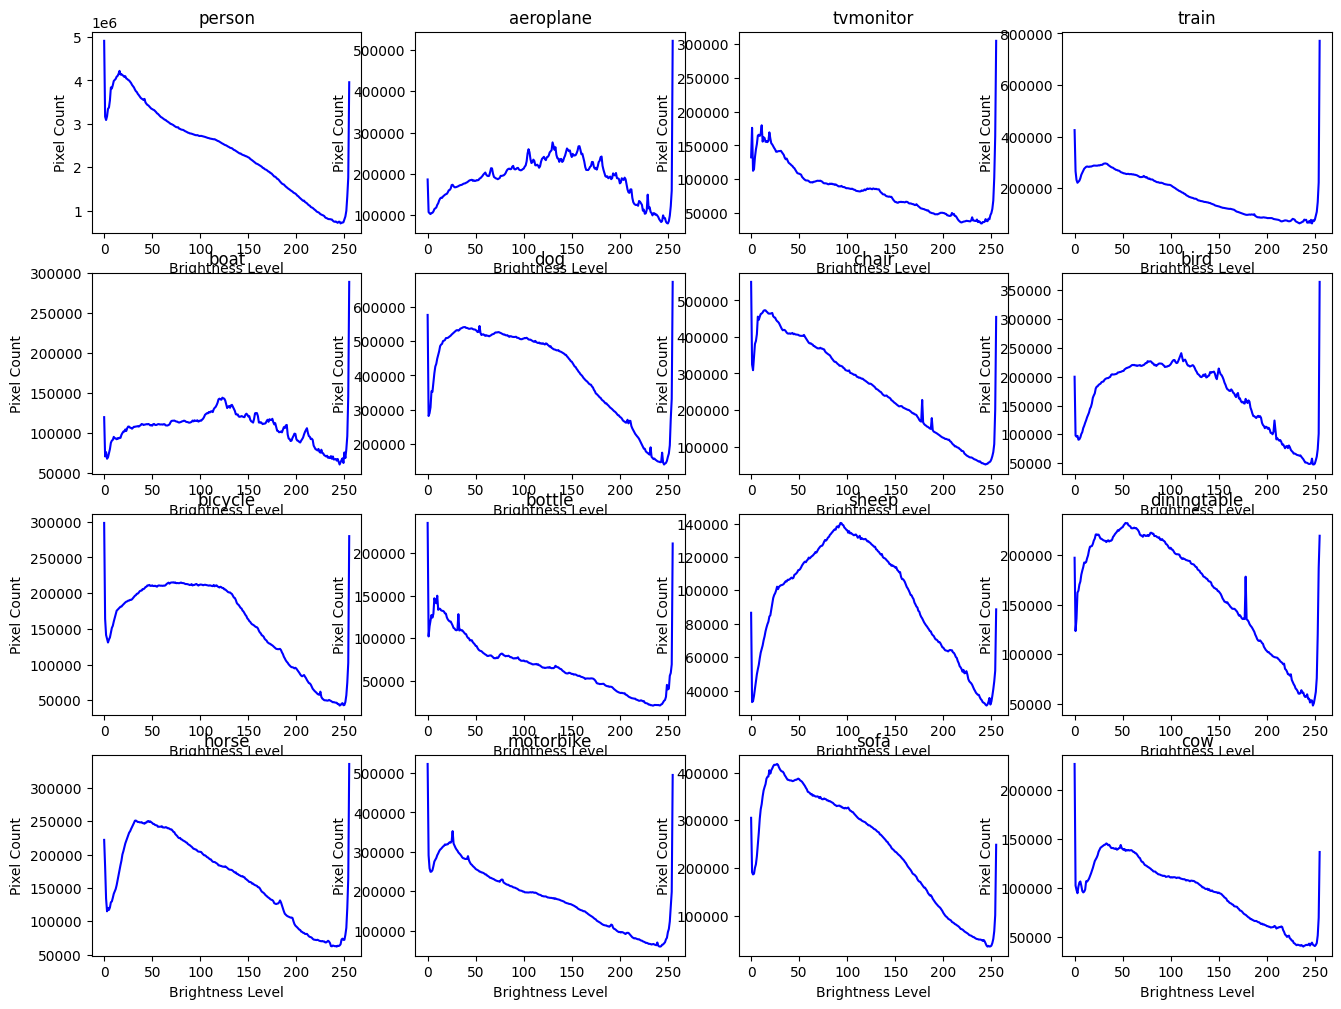

In [24]:
def show_brightness_distribution():
    """Analyze and plot brightness distribution in the dataset by category using histograms. Also plot combined distribution for all categories."""
    print("Analyzing brightness distribution by category...")

    try:
        # Dictionary to store brightness histograms by category
        category_brightness = {}
        # List to store all histograms for combined plot
        combined_brightness = []

        # Process all XML files in the annotation directory
        xml_files = [f for f in os.listdir(annot_dir) if f.endswith('.xml')]
        print(f"Found {len(xml_files)} XML files")

        for filename in xml_files:
            file_path = os.path.join(annot_dir, filename)
            tree = ET.parse(file_path)
            root = tree.getroot()

            # Get base filename without extension
            base_name = os.path.splitext(filename)[0]

            # Get corresponding image file
            image_file = os.path.join(images_dir, base_name + '.jpg')
            if not os.path.exists(image_file):
                continue

            # Load image
            img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)  # Load as grayscale for brightness analysis

            # Extract objects (annotations)
            for obj in root.findall('./object'):
                # Get category name
                category_name = obj.find('name').text

                # Get bounding box dimensions
                bbox = obj.find('bndbox')
                if bbox is not None:
                    xmin = int(float(bbox.find('xmin').text))
                    ymin = int(float(bbox.find('ymin').text))
                    xmax = int(float(bbox.find('xmax').text))
                    ymax = int(float(bbox.find('ymax').text))

                    # Crop the object from the image
                    cropped_img = img[ymin:ymax, xmin:xmax]

                    # Calculate brightness histogram using numpy
                    hist, _ = np.histogram(cropped_img, bins=256, range=(0, 256))

                    # Add histogram to the category
                    if category_name not in category_brightness:
                        category_brightness[category_name] = []
                    category_brightness[category_name].append(hist)

                    # Add to combined
                    combined_brightness.append(hist)

        # Aggregate histograms for each category
        aggregated_brightness = {}
        for category, histograms in category_brightness.items():
            aggregated_brightness[category] = np.sum(histograms, axis=0)

        # Plot brightness distributions as histograms
        plt.figure(figsize=(16, 12))
        for i, (category, hist) in enumerate(aggregated_brightness.items()):
            plt.subplot(4, 4, i + 1)
            plt.plot(hist, color='blue')
            plt.title(category)
            plt.xlabel('Brightness Level')
            plt.ylabel('Pixel Count')

        plt.tight_layout()
        plt.show()

        # Plot combined brightness distribution
        if combined_brightness:
            total_brightness = np.sum(combined_brightness, axis=0)
            plt.figure(figsize=(10, 6))
            plt.plot(total_brightness, color='purple')
            plt.title('Combined Brightness Distribution for All Categories')
            plt.xlabel('Brightness Level')
            plt.ylabel('Pixel Count')
            plt.grid(True, alpha=0.3)
            plt.tight_layout()
            plt.show()

    except Exception as e:
        print(f"Error analyzing brightness distribution: {e}")

show_brightness_distribution()

In [ ]:
def show_combined_brightness_distribution():
    """Analyze and plot combined brightness distribution for all images in the dataset."""
    print("Analyzing combined brightness distribution...")

    try:
        # List to store brightness histograms for all images
        combined_brightness = []

        # Process all XML files in the annotation directory
        xml_files = [f for f in os.listdir(annot_dir) if f.endswith('.xml')]
        print(f"Found {len(xml_files)} XML files")

        for filename in xml_files:
            file_path = os.path.join(annot_dir, filename)

            # Parse XML file
            tree = ET.parse(file_path)
            root = tree.getroot()

            # Get base filename without extension
            base_name = os.path.splitext(filename)[0]

            # Get corresponding image file
            image_file = os.path.join(images_dir, base_name + '.jpg')

            if not os.path.exists(image_file):
                continue

            # Load image
            img = cv2.imread(image_file, cv2.IMREAD_GRAYSCALE)  # Load as grayscale for brightness analysis

            # Extract objects (annotations)
            for obj in root.findall('./object'):
                # Get bounding box dimensions
                bbox = obj.find('bndbox')
                if bbox is not None:
                    xmin = int(float(bbox.find('xmin').text))
                    ymin = int(float(bbox.find('ymin').text))
                    xmax = int(float(bbox.find('xmax').text))
                    ymax = int(float(bbox.find('ymax').text))

                    # Crop the object from the image
                    cropped_img = img[ymin:ymax, xmin:xmax]

                    # Calculate brightness histogram using numpy
                    hist, _ = np.histogram(cropped_img, bins=256, range=(0, 256))

                    # Add histogram to the combined data
                    combined_brightness.append(hist)

        # Aggregate all histograms
        total_brightness = np.sum(combined_brightness, axis=0)

        # Plot combined brightness distribution
        plt.figure(figsize=(10, 6))
        plt.plot(total_brightness, color='blue')
        plt.title('Combined Brightness Distribution for All Images')
        plt.xlabel('Brightness Level')
        plt.ylabel('Pixel Count')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error analyzing combined brightness distribution: {e}")

# Call the function to display the combined brightness distribution
show_combined_brightness_distribution()

Now analyse colour distribution. This shows differences in category colour, but also differences across the whole dataset. This needs to be accounted for ahead of training. 

** PRE-PROCESSING ACTION ** 
    
    Albumentations: Include Colour jitter to randomise and improve generalisation. A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1, p=0.5)

In [7]:
def show_color_distribution_hsv():
    """Analyze and plot color distribution in the dataset by category using 2D KDE or Hexbin plots of HSV Hue-Saturation."""
    print("Analyzing color distribution in HSV by category...")

    try:
        # Dictionary to store HSV values by category
        category_hsv = {}

        # Process all XML files in the annotation directory
        xml_files = [f for f in os.listdir(annot_dir) if f.endswith('.xml')]
        print(f"Found {len(xml_files)} XML files")

        for filename in xml_files:
            file_path = os.path.join(annot_dir, filename)

            # Parse XML file
            tree = ET.parse(file_path)
            root = tree.getroot()

            # Get base filename without extension
            base_name = os.path.splitext(filename)[0]

            # Get corresponding image file
            image_file = os.path.join(images_dir, base_name + '.jpg')

            if not os.path.exists(image_file):
                continue

            # Load image
            img = cv2.imread(image_file)
            img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)  # Convert to HSV

            # Extract objects (annotations)
            for obj in root.findall('./object'):
                # Get category name
                category_name = obj.find('name').text

                # Get bounding box dimensions
                bbox = obj.find('bndbox')
                if bbox is not None:
                    xmin = int(float(bbox.find('xmin').text))
                    ymin = int(float(bbox.find('ymin').text))
                    xmax = int(float(bbox.find('xmax').text))
                    ymax = int(float(bbox.find('ymax').text))

                    # Crop the object from the image
                    cropped_img_hsv = img_hsv[ymin:ymax, xmin:xmax]

                    # Flatten Hue and Saturation channels
                    hue = cropped_img_hsv[:, :, 0].flatten()
                    saturation = cropped_img_hsv[:, :, 1].flatten()

                    # Add HSV values to the category
                    if category_name not in category_hsv:
                        category_hsv[category_name] = {'hue': [], 'saturation': []}
                    category_hsv[category_name]['hue'].extend(hue)
                    category_hsv[category_name]['saturation'].extend(saturation)

        # Plot HSV distributions as 2D KDE or Hexbin plots
        plt.figure(figsize=(16, 12))
        for i, (category, hsv_data) in enumerate(category_hsv.items()):
            plt.subplot(4, 4, i + 1)
            plt.hexbin(hsv_data['hue'], hsv_data['saturation'], gridsize=50, cmap='viridis', mincnt=1)
            plt.colorbar(label='Density')
            plt.title(category)
            plt.xlabel('Hue (0-180)')
            plt.ylabel('Saturation (0-255)')
            plt.xlim(0, 180)
            plt.ylim(0, 255)

        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error analyzing color distribution in HSV: {e}")

show_color_distribution_hsv()

Analyzing color distribution in HSV by category...
Found 17125 XML files
Error analyzing color distribution in HSV: 
Error analyzing color distribution in HSV: 


Analyse occlusions

** PRE-PROCESSING ACTION **

Add random occlusions to improve generalisation.

Analyzing occlusions in annotations from: C:\Users\curly\OneDrive\My Documents\Computer Science\Applied Machine Learning\Coursework\VOC2012\Annotations


Processing annotations: 100%|██████████| 17125/17125 [00:02<00:00, 7587.09it/s]



Total objects analyzed: 35676
Occluded objects: 11308
Overall occlusion rate: 31.70%


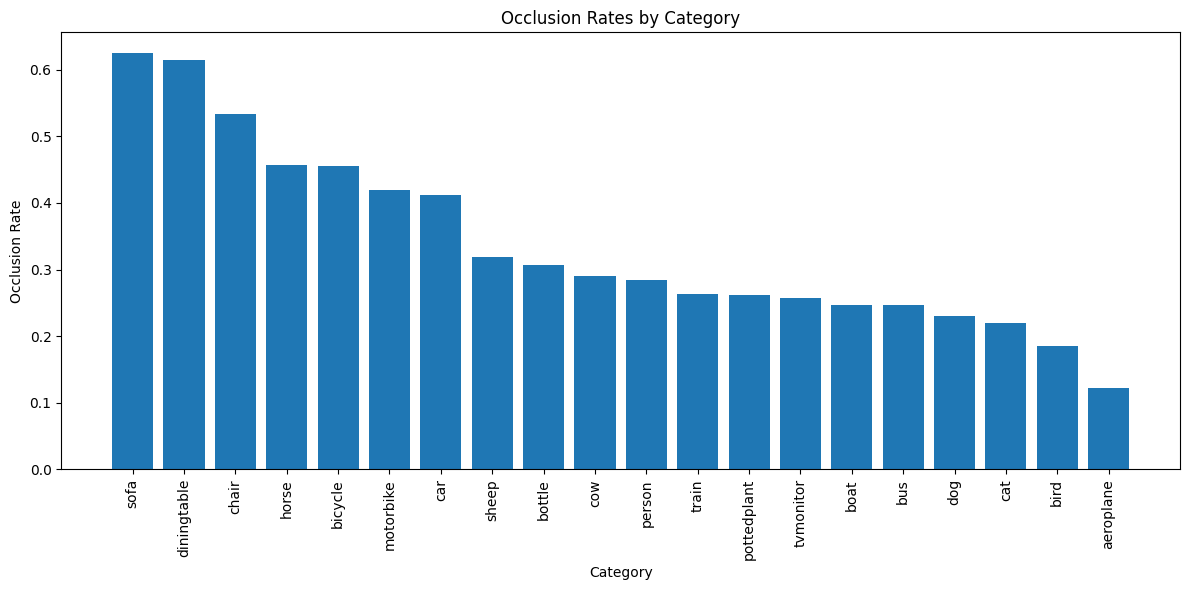

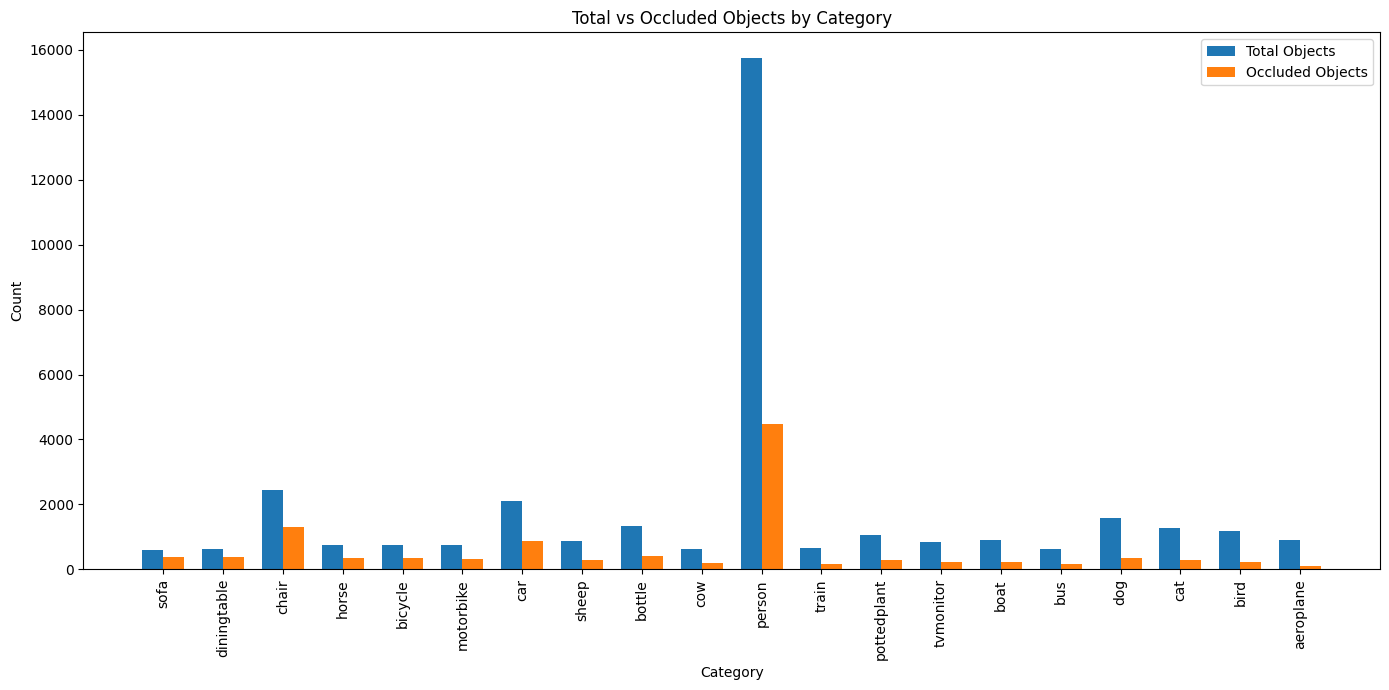


Top 5 categories with highest occlusion rates:
sofa: 62.50% (370/592 objects)
diningtable: 61.42% (390/635 objects)
chair: 53.30% (1302/2443 objects)
horse: 45.66% (347/760 objects)
bicycle: 45.55% (343/753 objects)

Top 5 categories with lowest occlusion rates:
bus: 24.61% (157/638 objects)
dog: 23.04% (362/1571 objects)
cat: 22.04% (279/1266 objects)
bird: 18.48% (216/1169 objects)
aeroplane: 12.18% (111/911 objects)


{'total_objects': 35676,
 'occluded_objects': 11308,
 'occlusion_rate': 0.3169637851777105,
 'category_counts': {'person': 15753,
  'aeroplane': 911,
  'tvmonitor': 839,
  'train': 672,
  'boat': 902,
  'dog': 1571,
  'chair': 2443,
  'bird': 1169,
  'bicycle': 753,
  'bottle': 1329,
  'sheep': 878,
  'horse': 760,
  'motorbike': 763,
  'sofa': 592,
  'cow': 642,
  'car': 2105,
  'cat': 1266,
  'bus': 638,
  'pottedplant': 1055,
  'diningtable': 635},
 'occluded_by_category': {'horse': 347,
  'bottle': 408,
  'tvmonitor': 216,
  'person': 4478,
  'dog': 362,
  'bicycle': 343,
  'boat': 222,
  'chair': 1302,
  'diningtable': 390,
  'sofa': 370,
  'cat': 279,
  'car': 868,
  'motorbike': 320,
  'train': 177,
  'aeroplane': 111,
  'bus': 157,
  'pottedplant': 276,
  'cow': 186,
  'bird': 216,
  'sheep': 280},
 'occlusion_rates_by_category': {'person': 0.2842633149241414,
  'aeroplane': 0.12184412733260154,
  'tvmonitor': 0.25744934445768775,
  'train': 0.26339285714285715,
  'boat': 0.246

: 

In [ ]:
def analyze_occlusions(annot_dir):
    """
    Analyze occlusions in VOC dataset annotations.
    
    Args:
        annot_dir: Directory containing annotation XML files
    
    Returns:
        Dictionary with analysis results
    """
    # Initialize counters
    total_objects = 0
    occluded_objects = 0
    category_counts = Counter()
    occluded_by_category = Counter()
    
    # Get all XML files
    xml_files = [f for f in os.listdir(annot_dir) if f.endswith('.xml')]
    
    # Process each file
    for xml_file in tqdm(xml_files, desc="Processing annotations"):
        tree = ET.parse(os.path.join(annot_dir, xml_file))
        root = tree.getroot()
        
        # Process each object in the annotation
        for obj in root.findall('./object'):
            category = obj.find('name').text
            
            # Safely get the 'difficult' and 'occluded' values, defaulting to 0 if missing
            difficult = int(obj.find('difficult').text) if obj.find('difficult') is not None else 0
            occluded = int(obj.find('occluded').text) if obj.find('occluded') is not None else 0
            
            # Count total objects (excluding difficult ones for fair analysis)
            if difficult == 0:
                total_objects += 1
                category_counts[category] += 1
                
                # Count occluded objects
                if occluded == 1:
                    occluded_objects += 1
                    occluded_by_category[category] += 1
    
    # Calculate percentages
    results = {
        'total_objects': total_objects,
        'occluded_objects': occluded_objects,
        'occlusion_rate': occluded_objects / total_objects if total_objects > 0 else 0,
        'category_counts': dict(category_counts),
        'occluded_by_category': dict(occluded_by_category),
        'occlusion_rates_by_category': {
            cat: occluded_by_category[cat] / category_counts[cat] 
            if category_counts[cat] > 0 else 0
            for cat in category_counts
        }
    }
    
    return results

def visualize_occlusions(results):
    """
    Create visualizations for occlusion analysis.
    
    Args:
        results: Results dictionary from analyze_occlusions
    """
    # Overall occlusion rate
    print(f"Total objects analyzed: {results['total_objects']}")
    print(f"Occluded objects: {results['occluded_objects']}")
    print(f"Overall occlusion rate: {results['occlusion_rate']:.2%}")
    
    # Get categories sorted by occlusion rate
    categories = sorted(
        results['occlusion_rates_by_category'].keys(),
        key=lambda x: results['occlusion_rates_by_category'][x],
        reverse=True
    )
    
    # Plot occlusion rates by category
    plt.figure(figsize=(12, 6))
    
    # Filter categories that have at least 10 instances for reliable statistics
    filtered_categories = [cat for cat in categories if results['category_counts'][cat] >= 10]
    rates = [results['occlusion_rates_by_category'][cat] for cat in filtered_categories]
    counts = [results['category_counts'][cat] for cat in filtered_categories]
    
    plt.bar(filtered_categories, rates)
    plt.xlabel('Category')
    plt.ylabel('Occlusion Rate')
    plt.title('Occlusion Rates by Category')
    plt.xticks(rotation=90)
    plt.tight_layout()
    
    # Plot counts and occlusions side by side
    plt.figure(figsize=(14, 7))
    x = np.arange(len(filtered_categories))
    width = 0.35
    
    plt.bar(x - width/2, [results['category_counts'][cat] for cat in filtered_categories], 
            width, label='Total Objects')
    plt.bar(x + width/2, [results['occluded_by_category'].get(cat, 0) for cat in filtered_categories], 
            width, label='Occluded Objects')
    
    plt.xlabel('Category')
    plt.ylabel('Count')
    plt.title('Total vs Occluded Objects by Category')
    plt.xticks(x, filtered_categories, rotation=90)
    plt.legend()
    plt.tight_layout()
    
    plt.show()
    
    # Print categories with highest occlusion rates
    print("\nTop 5 categories with highest occlusion rates:")
    for cat in categories[:5]:
        print(f"{cat}: {results['occlusion_rates_by_category'][cat]:.2%} " 
              f"({results['occluded_by_category'].get(cat, 0)}/{results['category_counts'][cat]} objects)")
    
    # Print categories with lowest occlusion rates
    print("\nTop 5 categories with lowest occlusion rates:")
    for cat in categories[-5:]:
        print(f"{cat}: {results['occlusion_rates_by_category'][cat]:.2%} "
              f"({results['occluded_by_category'].get(cat, 0)}/{results['category_counts'][cat]} objects)")

# Example usage
def run_occlusion_analysis():
    print(f"Analyzing occlusions in annotations from: {annot_dir}")
    results = analyze_occlusions(annot_dir)
    visualize_occlusions(results)
    return results

run_occlusion_analysis()